<a href="https://colab.research.google.com/github/shivendr7/ml/blob/GANs/stable_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels)=mnist.load_data()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, Dense, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [3]:
def build_discriminator():
  init=RandomNormal(stddev=0.2)
  model=Sequential()
  model.add(Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
disc=build_discriminator()

In [4]:
disc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [5]:
def build_generator(latent_dim):
  init=RandomNormal(stddev=0.2)
  model=Sequential()
  model.add(Dense(128*7*7, input_shape=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape(target_shape=(7,7,128)))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, kernel_size=(7,7), padding='same', activation='tanh', kernel_initializer=init))
  return model
gen=build_generator(latent_dim=(100,))

In [6]:
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)      

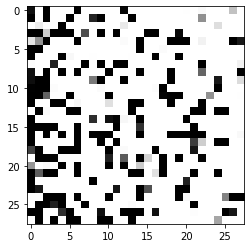

In [7]:
im=gen.predict(np.random.randn(100).reshape(1,100))
plt.imshow(im.reshape(28,28), cmap='gray_r')

In [8]:
def build_gan():
  disc.trainable=False
  model=Sequential()
  model.add(gen)
  model.add(disc)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
gan=build_gan()

In [9]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1165313   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 70337     
Total params: 1,235,650
Trainable params: 1,164,801
Non-trainable params: 70,849
_________________________________________________________________


In [10]:
X=np.expand_dims(train_images, axis=-1)
images_with_class8=train_labels==8
X=X[images_with_class8]

In [11]:
Xf=X.astype('float32')
Xf=(Xf-127.5)/127.5

In [12]:
def generate_real_samples(n):
  ix=np.random.randint(0, Xf.shape[0], n)
  x=Xf[ix]
  y=np.ones(shape=(n,1))
  return x,y
x_1, y_1=generate_real_samples(10)
x_1.shape, y_1.shape

((10, 28, 28, 1), (10, 1))

In [13]:
def generate_latent_points(n):
  return np.random.randn(100*n).reshape(n,100)
def generate_fake_samples(n):
  x=generate_latent_points(n)
  x=gen.predict(x)
  y=np.zeros(shape=(n,1))
  return x,y
x_1, y_1=generate_fake_samples(10)
x_1.shape, y_1.shape

((10, 28, 28, 1), (10, 1))

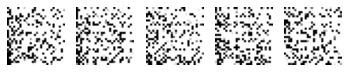

In [14]:
def summarise_performance():
  x,_ =generate_fake_samples(5)
  x=(x+1)/2 #[-1,1]->[0,1]
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(x[i,:,:,0], cmap='gray_r')
  
summarise_performance()

In [15]:
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
  plt.subplot(2,1,1)
  plt.plot(d1_hist, label='d_real')
  plt.plot(d2_hist, label='d_fake')
  plt.plot(g_hist, label='gen')
  plt.legend()
  plt.subplot(2,1,2) 
  plt.plot(a1_hist, label='acc_real')
  plt.plot(a2_hist, label='acc_fake')
  plt.legend()
  plt.close()

In [16]:
def train(n_epochs=100, n_batch=128):
  batch_per_epoch=Xf.shape[0]//n_batch
  half_batch=n_batch//2
  n=batch_per_epoch*n_epochs
  d1_hist=[];d2_hist=[];g_hist=[];a1_hist=[];a2_hist=[]
  for i in range(n):
    x_r, y_r=generate_real_samples(half_batch)
    d_loss1, d_acc1=disc.train_on_batch(x_r, y_r)
    x_f, y_f=generate_fake_samples(half_batch)
    d_loss2, d_acc2=disc.train_on_batch(x_f, y_f)
    x_g=generate_latent_points(n_batch)
    y_g=np.ones(shape=(n_batch,1))
    g_loss, _ =gan.train_on_batch(x_g, y_g)
    print('%d d1=[%.3f] d2=[%.3f] g=[%.3f] a1=[%d] a2=[%d]'%(i+1,d_loss1, d_loss2, g_loss, d_acc1, d_acc2))
    d1_hist.append(d_loss1)
    d2_hist.append(d_loss2)
    g_hist.append(g_loss)
    a1_hist.append(d_acc1)
    a2_hist.append(d_acc2)
    """
    if((i+1)%5==0):
      summarise_performance() """
  plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)

In [19]:
train()

1 d1=[0.037] d2=[0.026] g=[0.745] a1=[1] a2=[1]
2 d1=[0.017] d2=[0.031] g=[1.600] a1=[1] a2=[1]
3 d1=[0.025] d2=[0.020] g=[1.582] a1=[1] a2=[1]
4 d1=[0.024] d2=[0.020] g=[1.505] a1=[1] a2=[1]
5 d1=[0.013] d2=[0.023] g=[1.615] a1=[1] a2=[1]
6 d1=[0.021] d2=[0.017] g=[1.657] a1=[1] a2=[1]
7 d1=[0.013] d2=[0.016] g=[1.578] a1=[1] a2=[1]
8 d1=[0.016] d2=[0.023] g=[1.606] a1=[1] a2=[1]
9 d1=[0.021] d2=[0.012] g=[1.618] a1=[1] a2=[1]
10 d1=[0.012] d2=[0.011] g=[1.527] a1=[1] a2=[1]
11 d1=[0.023] d2=[0.015] g=[1.411] a1=[1] a2=[1]
12 d1=[0.018] d2=[0.018] g=[1.379] a1=[1] a2=[1]
13 d1=[0.032] d2=[0.016] g=[1.224] a1=[1] a2=[1]
14 d1=[0.022] d2=[0.015] g=[1.079] a1=[1] a2=[1]
15 d1=[0.018] d2=[0.019] g=[1.095] a1=[1] a2=[1]
16 d1=[0.015] d2=[0.019] g=[1.190] a1=[1] a2=[1]
17 d1=[0.024] d2=[0.022] g=[1.123] a1=[1] a2=[1]
18 d1=[0.021] d2=[0.015] g=[1.097] a1=[1] a2=[1]
19 d1=[0.013] d2=[0.017] g=[1.119] a1=[1] a2=[1]
20 d1=[0.019] d2=[0.017] g=[1.186] a1=[1] a2=[1]
21 d1=[0.016] d2=[0.015] g=[1

KeyboardInterrupt: ignored

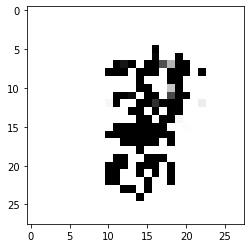

In [18]:
im=gen.predict(np.random.randn(100).reshape(1,100))
plt.imshow(im.reshape(28,28), cmap='gray_r')

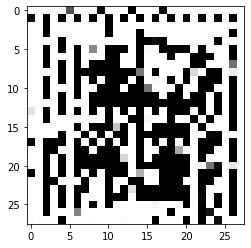

In [20]:
im=gen.predict(np.random.randn(100).reshape(1,100))
plt.imshow(im.reshape(28,28), cmap='gray_r')